# Capstone 2 Modeling
## NBA Salary Predictor and Trade Suggestion
## Austin Cody
#### Models to attempt: Lasso Regression, Random Forest Regressor, XGBoost
#### Tuning techniques: GridsearchCV, Bayesian Optimization
#### Linear Programming to optimize team based on budget

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# increasing the number of displayable columns to better examine all dummy variables 
pd.set_option('display.max_columns', 63)
pd.set_option('display.max_rows', 63)

In [35]:
def print_metrics(y_test,y_pred):
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f'Mean Squared Error: {rmse}')

    mae = mean_absolute_error(y_test, y_pred)
    print(f'Mean Absolute Error: {mae}')

    r2 = r2_score(y_test, y_pred)
    print(f'R-squared: {r2}')

In [36]:
# reading in csv, splitting data into train/test
df = pd.read_csv('nba_salaries_dummies.csv')
features = ['age','2_pointers_pg','3_pointers_pg','free_throws_pg','assists_pg','points_pg', 'minutes_pg']

X = df[features].values
y = df['salary'].values

# We will do optimization and kfold cross validation on the training set and we don't even touch our test set until the final eval
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [37]:
#scaling from previous notebook
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Linear Regression using Lasso Regularization and hyperparameter tuning using RandomSearchCV

In [38]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold

params = {'alpha': [0.01, 0.1, 1.0, 10.0]}
lasso = Lasso(max_iter=100000)
lasso_gscv = GridSearchCV(lasso, param_grid=params, cv=5, scoring='r2')
lasso_gscv.fit(X_train_scaled,y_train)

best_alpha = lasso_gscv.best_params_['alpha']

best_lasso = Lasso(alpha=best_alpha, max_iter=100000)
best_lasso.fit(X_train_scaled, y_train)
y_pred_test = best_lasso.predict(X_test_scaled)
y_pred_train = best_lasso.predict(X_train_scaled)

In [39]:
print("Optimal Alpha value for Lasso Regression")
print(best_alpha)

Optimal Alpha value for Lasso Regression
10.0


In [40]:
# Evaluating Lasso Regression model
print("Lasso Regression using best alpha:\n")
print('Train Set:')
print_metrics(y_train,y_pred_train)
print('\nTest Set:')
print_metrics(y_test,y_pred_test)

Lasso Regression using best alpha:

Train Set:
Mean Squared Error: 6012693.684319544
Mean Absolute Error: 4469535.426137853
R-squared: 0.7158305036163621

Test Set:
Mean Squared Error: 6866497.163811419
Mean Absolute Error: 4938687.626331326
R-squared: 0.5398459201700779


In [41]:
# cross validation
from sklearn.model_selection import cross_val_score, KFold
kf = KFold(n_splits=4, shuffle=True)
cv_results = cross_val_score(best_lasso, X, y, cv=kf, scoring='r2')
np.mean(cv_results)

0.6498795463429899

## Random Forest Regressor Bayesian Optimization 

In [42]:
from sklearn.ensemble import RandomForestRegressor
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score, KFold

#optimizes r2 for our random forest regressor
def rfr_objective_function(n_estimators,max_depth,min_samples_split,min_samples_leaf,max_features,max_leaf_nodes):
    rfr = RandomForestRegressor(n_estimators=int(n_estimators),
                                max_depth=int(max_depth),
                                min_samples_split=int(min_samples_split),
                                min_samples_leaf=int(min_samples_leaf),
                                max_features=int(max_features),
                                max_leaf_nodes=int(max_leaf_nodes))

    # cross validating inside our objective functions avoids overfitting to our individual set of data
    kf = KFold(n_splits=5, shuffle=True)
    cv_scores = cross_val_score(rfr, X_train_scaled, y_train, cv=kf, scoring='r2')

    return np.mean(cv_scores)

rfr_bo = BayesianOptimization(f = rfr_objective_function,
                                pbounds = {'n_estimators':(10,1000),
                                           'max_depth':(1,10),
                                           'min_samples_split':(2,10),
                                           'min_samples_leaf':(1,10),
                                           'max_features':(3,len(features)),
                                           'max_leaf_nodes':(2,50)})

rfr_bo.maximize(n_iter=15, init_points=5)

|   iter    |  target   | max_depth | max_fe... | max_le... | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------------------
| 1         | 0.4911    | 1.967     | 6.169     | 8.722     | 4.695     | 3.444     | 12.64     |
| 2         | 0.7155    | 9.189     | 6.584     | 10.5      | 3.687     | 7.293     | 275.4     |
| 3         | 0.4803    | 1.859     | 6.195     | 19.35     | 7.236     | 7.53      | 36.45     |
| 4         | 0.6921    | 8.533     | 3.022     | 28.47     | 4.04      | 7.675     | 486.0     |
| 5         | 0.6659    | 8.656     | 3.446     | 44.9      | 7.233     | 9.68      | 902.4     |
| 6         | 0.4631    | 1.0       | 7.0       | 2.0       | 10.0      | 2.0       | 694.3     |
| 7         | 0.5161    | 1.0       | 3.749     | 50.0      | 5.542     | 4.563     | 372.9     |
| 8         | 0.457     | 10.0      | 7.0       | 2.0       | 1.0       | 6.97      | 222.1     |
| 9         | 0.733 

In [43]:
print("Optimal Parameters for Random Forest Regressor")
for key, value in rfr_bo.max['params'].items():
    print("{}: {}".format(key,value))

Optimal Parameters for Random Forest Regressor
max_depth: 10.0
max_features: 6.8797228944894755
max_leaf_nodes: 9.121185011960904
min_samples_leaf: 3.522076093491133
min_samples_split: 7.679135669515159
n_estimators: 273.027912018116


In [44]:
rfr_optimized = RandomForestRegressor(max_depth = int(rfr_bo.max['params']['max_depth']),
                                      max_features = int(rfr_bo.max['params']['max_features']),
                                      max_leaf_nodes = int(rfr_bo.max['params']['max_leaf_nodes']),
                                      min_samples_leaf = int(rfr_bo.max['params']['min_samples_leaf']),
                                      min_samples_split = int(rfr_bo.max['params']['min_samples_split']),
                                      n_estimators = int(rfr_bo.max['params']['n_estimators']))
rfr_optimized.fit(X_train_scaled,y_train)
y_pred_test = rfr_optimized.predict(X_test_scaled)
y_pred_train = rfr_optimized.predict(X_train_scaled)

# Evaluating Best Random Forest Regressor
print("Bayesian Optimized Random Forest Regressor:\n")
print('Train Set:')
print_metrics(y_train,y_pred_train)
print('\nTest Set:')
print_metrics(y_test,y_pred_test)

Bayesian Optimized Random Forest Regressor:

Train Set:
Mean Squared Error: 4329442.7362129735
Mean Absolute Error: 3085866.686657296
R-squared: 0.852665891878133

Test Set:
Mean Squared Error: 5889335.104231516
Mean Absolute Error: 3771573.0761061274
R-squared: 0.6614948192721251


In [45]:
#cross validation using the optimized random forest regressor
from sklearn.model_selection import cross_val_score, KFold
kf = KFold(n_splits=4, shuffle=True)
cv_results = cross_val_score(rfr_optimized, X, y, cv=kf, scoring='r2')
np.mean(cv_results)

0.6893050468153958

## XGBoost with Bayesian Optimization 

In [46]:
from xgboost import XGBRegressor

#optimizes rmse for our linear model
def xgb_objective_function(learning_rate,max_depth,subsample,colsample_bytree,reg_lambda,reg_alpha):
    # instantiating xgbregressor
    xgb = XGBRegressor(objective='reg:squarederror',
                       learning_rate=learning_rate, 
                       max_depth=int(max_depth), 
                       subsample=subsample, 
                       colsample_bytree=colsample_bytree,
                       reg_lambda=reg_lambda, 
                       reg_alpha=reg_alpha)

    # cross validating inside our objective functions avoids overfitting to our individual set of data
    kf = KFold(n_splits=5, shuffle=True)
    cv_scores = cross_val_score(xgb, X_train_scaled, y_train, cv=kf, scoring='r2')

    return np.mean(cv_scores)

xgb_bo = BayesianOptimization(f = xgb_objective_function,
                                pbounds = {'learning_rate':(0.01,0.3),
                                           'max_depth':(1,10), 
                                           'subsample':(0.5,1.0),
                                           'colsample_bytree':(0.5,1.0),
                                           'reg_lambda':(0.01,5),
                                           'reg_alpha':(0.01,5)})

xgb_bo.maximize(n_iter=15, init_points=5)

|   iter    |  target   | colsam... | learni... | max_depth | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------
| 1         | 0.677     | 0.5918    | 0.2912    | 7.331     | 2.864     | 2.086     | 0.6542    |
| 2         | 0.6785    | 0.9731    | 0.2872    | 4.847     | 0.7722    | 0.7883    | 0.7704    |
| 3         | 0.683     | 0.8477    | 0.2289    | 4.11      | 2.453     | 4.844     | 0.6695    |
| 4         | 0.68      | 0.8533    | 0.1666    | 4.472     | 1.588     | 4.576     | 0.5735    |
| 5         | 0.6022    | 0.9779    | 0.2275    | 1.63      | 4.349     | 1.829     | 0.6485    |
| 6         | 0.6811    | 0.6925    | 0.1233    | 8.48      | 0.04062   | 0.09422   | 0.9378    |
| 7         | 0.6396    | 1.0       | 0.3       | 9.436     | 0.01      | 4.888     | 1.0       |
| 8         | 0.5213    | 1.0       | 0.01      | 10.0      | 3.434     | 0.01      | 1.0       |
| 9         | 0.6372

In [47]:
print("Optimal Parameters for XGBRegressor")
for key, value in xgb_bo.max['params'].items():
    print("{}: {}".format(key,value))

Optimal Parameters for XGBRegressor
colsample_bytree: 0.7646628486150144
learning_rate: 0.13082659964802654
max_depth: 3.320737742081863
reg_alpha: 1.592571812150734
reg_lambda: 5.0
subsample: 0.5


In [48]:
# using the best hyperparameters when creating our XGBRegressor object
xgb_optimized = XGBRegressor(learning_rate = xgb_bo.max['params']['learning_rate'],
                                      max_depth = int(xgb_bo.max['params']['max_depth']),
                                      subsample = xgb_bo.max['params']['subsample'],
                                      colsample_bytree = xgb_bo.max['params']['colsample_bytree'],
                                      reg_lambda = xgb_bo.max['params']['reg_lambda'],
                                      reg_alpha = xgb_bo.max['params']['reg_alpha'])
xgb_optimized.fit(X_train_scaled,y_train)
y_pred_test = xgb_optimized.predict(X_test_scaled)
y_pred_train = xgb_optimized.predict(X_train_scaled)

# Evaluating Best XGBoost Model
print("Bayesian Optimized XGBoost:\n")
print('Train Set:')
print_metrics(y_train,y_pred_train)
print('\nTest Set:')
print_metrics(y_test,y_pred_test)

Bayesian Optimized XGBoost:

Train Set:
Mean Squared Error: 2792837.734256235
Mean Absolute Error: 1944750.960468198
R-squared: 0.9386900861078348

Test Set:
Mean Squared Error: 5762343.341129091
Mean Absolute Error: 3732529.651639344
R-squared: 0.6759358047247441


In [49]:
#cross validation using the optimized xgbregressor
kf = KFold(n_splits=4, shuffle=True)
cv_results = cross_val_score(xgb_optimized, X, y, cv=kf, scoring='r2')
np.mean(cv_results)

0.7112524419560456

# Best Model
Our Bayesian optimized XGBoost and Random Forest Regressor models seemed to be the strongest and were very similar in performance. Our Random Forest model is the best way to go. The XGBoost model tended to overfit. 

# Identifying Ideal Trade for the Brooklyn Nets

In [50]:
df.head()

,name,salary,age,games_played,games_started,minutes_pg,field_goals_pg,field_goal_attempts_pg,field_goal_%,3_pointers_pg,3_point_attempts_pg,3_point_%,2_pointers_pg,2_point_attempts_pg,2_point_%,effective_field_goal_%,free_throws_pg,free_throw_attempts_pg,free_throw_%,o_rebounds_pg,d_rebounds_pg,total_rebounds_pg,assists_pg,steals_pg,blocks_pg,turnovers_pg,personal_fouls_pg,points_pg,position_C,position_PF,position_PG,position_SF,position_SG,team_ATL,team_BOS,team_BRK,team_CHI,team_CHO,team_CLE,team_DAL,team_DEN,team_DET,team_GSW,team_HOU,team_IND,team_LAC,team_LAL,team_MEM,team_MIA,team_MIL,team_MIN,team_NOP,team_NYK,team_OKC,team_ORL,team_PHI,team_PHO,team_POR,team_SAC,team_SAS,team_TOR,team_UTA,team_WAS
0,Stephen Curry,48070014,34,56,56,34.7,10.0,20.2,0.493,4.9,11.4,0.427,5.1,8.8,0.579,0.614,4.6,5.0,0.915,0.7,5.4,6.1,6.3,0.9,0.4,3.2,2.1,29.4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,John Wall,47345760,32,34,3,22.2,4.1,9.9,0.408,1.0,3.2,0.303,3.1,6.7,0.459,0.457,2.3,3.3,0.681,0.4,2.3,2.7,5.2,0.8,0.4,2.4,1.7,11.4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Russell Westbrook,47080179,34,73,24,29.1,5.9,13.6,0.436,1.2,3.9,0.311,4.7,9.7,0.487,0.481,2.8,4.3,0.656,1.2,4.6,5.8,7.5,1.0,0.5,3.5,2.2,15.9,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,LeBron James,44474988,38,55,54,35.5,11.1,22.2,0.500,2.2,6.9,0.321,8.9,15.3,0.580,0.549,4.6,5.9,0.768,1.2,7.1,8.3,6.8,0.9,0.6,3.2,1.6,28.9,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Kevin Durant,44119845,34,47,47,35.6,10.3,18.3,0.560,2.0,4.9,0.404,8.3,13.4,0.617,0.614,6.5,7.1,0.919,0.4,6.3,6.7,5.0,0.7,1.4,3.3,2.1,29.1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


### Predicting Brooklyn Nets Player salaries
Goal is to determine which players on the Brooklyn Nets are the most overvalued

In [51]:
X = df[features].values
X_scaled = scaler.transform(X)
salary_predictions_all = rfr_optimized.predict(X_scaled)
df.loc[:,'salary_predicted'] = [int(salary) for salary in salary_predictions_all]
df.loc[:,'salary_prediction_error'] = df['salary'] - df['salary_predicted']
df[['name','salary','salary_predicted','salary_prediction_error']].sort_values('salary_prediction_error',ascending=False).head()

,name,salary,salary_predicted,salary_prediction_error
19,Ben Simmons,35448672,8054004,27394668
1,John Wall,47345760,26274204,21071556
16,Tobias Harris,37633050,18049876,19583174
10,Klay Thompson,40600080,21372678,19227402
35,Kevin Love,30556968,13485236,17071732


In [52]:
df_brooklyn_nets = df[df['team_BRK']==1]
df_brooklyn_nets[['name','salary','salary_predicted','salary_prediction_error']].sort_values('salary_prediction_error',ascending=False).head()

,name,salary,salary_predicted,salary_prediction_error
19,Ben Simmons,35448672,8054004,27394668
64,Joe Harris,18642857,10679869,7962988
4,Kevin Durant,44119845,38377219,5742626
129,Nerlens Noel,9391069,3898863,5492206
11,Kyrie Irving,38917057,36352024,2565033


In [53]:
# Our XGBoost Model predicts that Ben Simmons is the Brooklyn Nets most OVER-valued player. He would be a good target for a trade
# idxmax finds the index at which a columns max value occurs
most_overvalued = df_brooklyn_nets.loc[df_brooklyn_nets['salary_prediction_error'].idxmax()]

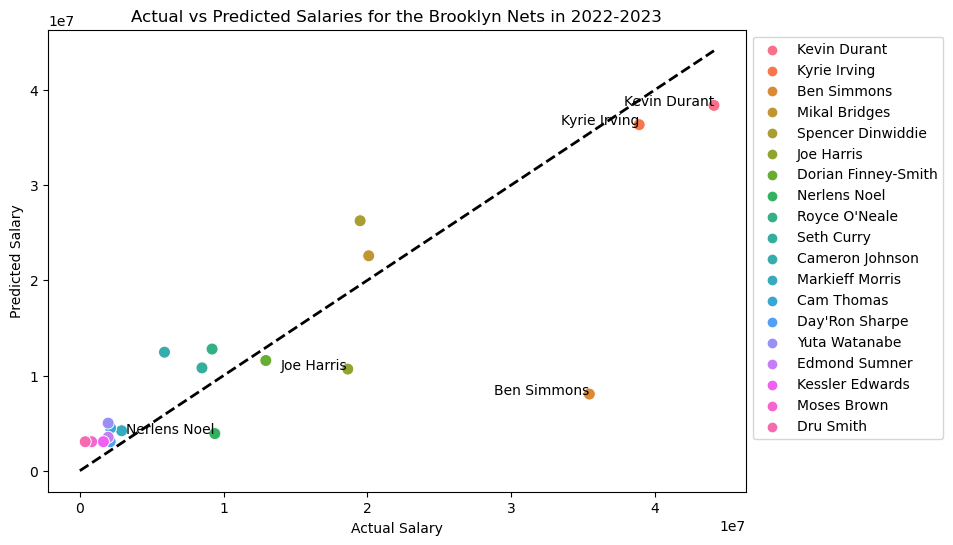

In [54]:
# Let's visualize
plt.figure(figsize=(9, 6))
scat_plot = sns.scatterplot(x='salary', 
                y='salary_predicted', 
                data=df_brooklyn_nets, 
                hue='name',
                s=75)

# Annotate each point with the player's name BUT just the top 3 most over valued so it doesn't look too chaotic
for index, row in df_brooklyn_nets.sort_values('salary_prediction_error',ascending=False).head(5).iterrows():
    scat_plot.text(row['salary'], row['salary_predicted'], row['name'], fontsize=10, ha='right')

# diagonal line for reference line is perfect predictions
plt.plot([0, df_brooklyn_nets['salary'].max()],
         [0, df_brooklyn_nets['salary'].max()], 
         'k--',
         linewidth=2)

plt.xlabel('Actual Salary')
plt.ylabel('Predicted Salary')
plt.title('Actual vs Predicted Salaries for the Brooklyn Nets in 2022-2023')

plt.legend(bbox_to_anchor=(1,1))

plt.show()

# We can see Ben Simmons, our prediction for most overvalued player is well below the line on the lower right
# Ben Simmons by far has the largest residual below our reference line

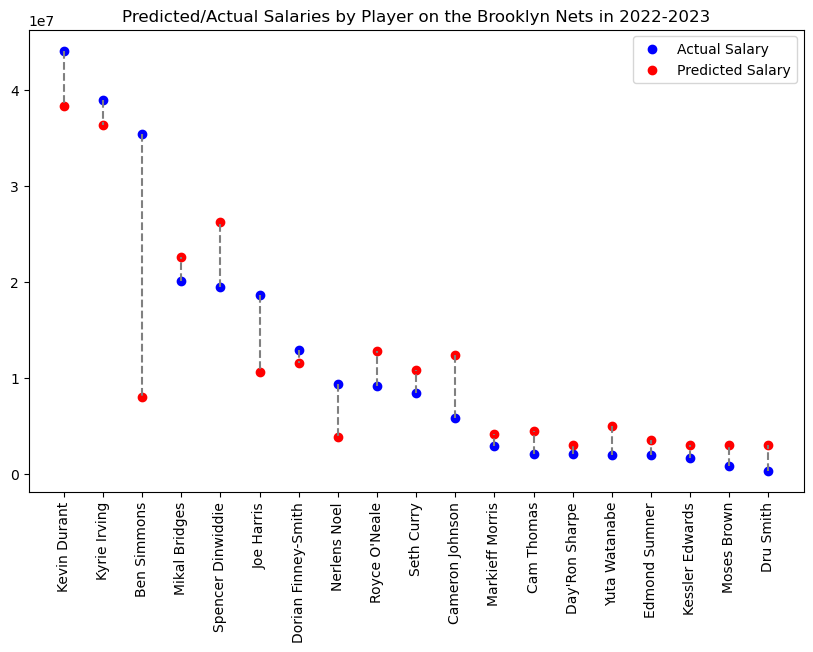

In [55]:
plt.figure(figsize=(10, 6))

plt.scatter(df_brooklyn_nets['name'], df_brooklyn_nets['salary'], color='blue', label='Actual Salary')
plt.scatter(df_brooklyn_nets['name'], df_brooklyn_nets['salary_predicted'], color='red', label= 'Predicted Salary')

for i in range(len(df_brooklyn_nets)):
    plt.plot([df_brooklyn_nets.iloc[i]['name'], df_brooklyn_nets.iloc[i]['name']],
             [df_brooklyn_nets.iloc[i]['salary'], df_brooklyn_nets.iloc[i]['salary_predicted']],
             color='gray', linestyle='--')

plt.title('Predicted/Actual Salaries by Player on the Brooklyn Nets in 2022-2023')
plt.legend()
plt.xticks(rotation=90)
plt.show()

### Predicting NBA Player salaries who are not on the Nets
Goal is to determine which players in the NBA who are not on the Nets are the most UNDER-valued

In [56]:
df_not_nets = df[df['team_BRK']!=1]
df_not_nets[['name','salary','salary_predicted','salary_prediction_error']].sort_values('salary_prediction_error',ascending=True).head()

,name,salary,salary_predicted,salary_prediction_error
301,Desmond Bane,2130240,22083727,-19953487
94,Jordan Clarkson,13340000,27663731,-14323731
378,Kris Dunn,1000001,12034058,-11034057
96,Kyle Kuzma,13000000,23301612,-10301612
44,DeMar DeRozan,27300000,36924344,-9624344


In [57]:
# Our XGBoost Model predicts that Desmond Bane is the NBA's most UNDER-valued player. The players above would be a good target for a trade
# idxmax finds the index at which a columns max value occurs
most_undervalued = df_not_nets.loc[df_not_nets['salary_prediction_error'].idxmax()]

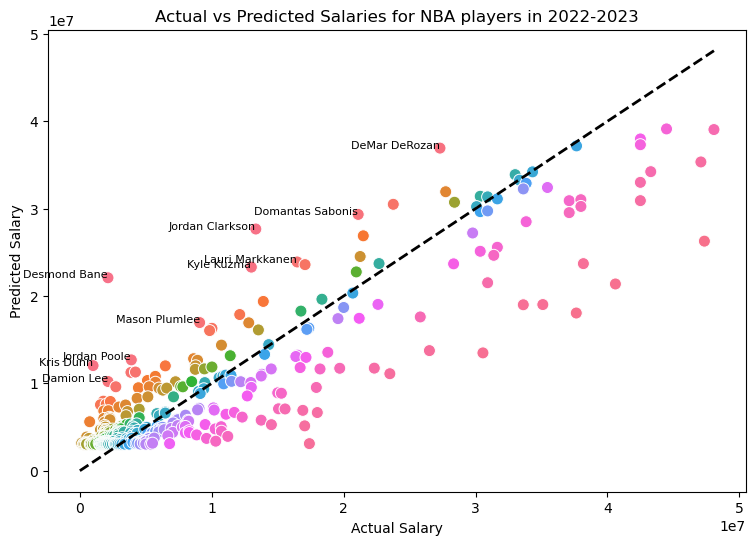

In [58]:
plt.figure(figsize=(9, 6))
scat_plot = sns.scatterplot(x='salary', 
                y='salary_predicted', 
                data=df_not_nets.sort_values('salary_prediction_error',ascending=True),
                hue='name',
                s=75,legend=False)

# Annotate each point with the player's name BUT just the top 10 most under valued so it doesn't look too chaotic
for index, row in df_not_nets.sort_values('salary_prediction_error',ascending=True).head(10).iterrows():
    scat_plot.text(row['salary'], row['salary_predicted'], row['name'], fontsize=8, ha='right')

# diagonal line for reference line is perfect predictions
plt.plot([0, df_not_nets['salary'].max()],
         [0, df_not_nets['salary'].max()], 
         'k--',
         linewidth=2)

plt.xlabel('Actual Salary')
plt.ylabel('Predicted Salary')
plt.title('Actual vs Predicted Salaries for NBA players in 2022-2023')

plt.show()

# The named players below are the most undervalued players in the NBA who are not on the Brooklyn Nets

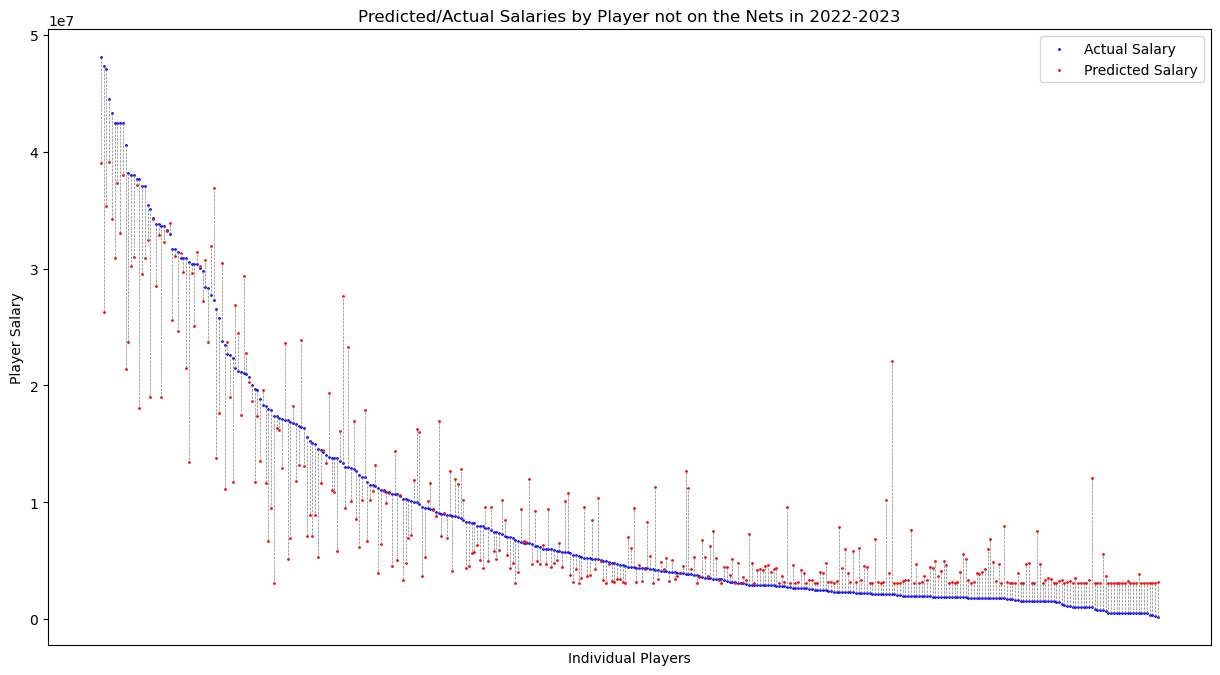

In [59]:
plt.figure(figsize=(15, 8))

plt.scatter(df_not_nets['name'], df_not_nets['salary'], color='blue', label='Actual Salary',s=1)
plt.scatter(df_not_nets['name'], df_not_nets['salary_predicted'], color='red', label= 'Predicted Salary',s=1)

for i in range(len(df_not_nets)):
    plt.plot([df_not_nets.iloc[i]['name'], df_not_nets.iloc[i]['name']],
             [df_not_nets.iloc[i]['salary'], df_not_nets.iloc[i]['salary_predicted']],
             color='gray', linestyle='--',linewidth=0.5)

plt.title('Predicted/Actual Salaries by Player not on the Nets in 2022-2023')
plt.legend()
plt.xlabel('Individual Players')
plt.ylabel('Player Salary')
plt.xticks([])
plt.show()

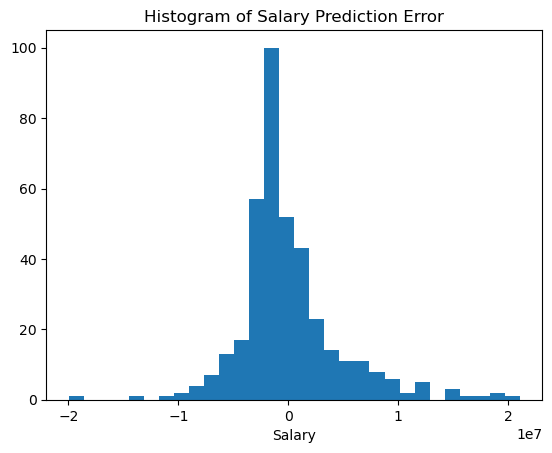

In [60]:
#Visualizing Error
plt.hist(df_not_nets['salary_prediction_error'],bins=30)
plt.title('Histogram of Salary Prediction Error')
plt.xlabel('Salary')
plt.show()

# Linear Programming for Optimizing team
#### assumptions are 15-18 person team, stay within budget of $157,271,491, count of each position >= 3

In [61]:
from pulp import *

players = [player for player in df['name']]
salaries_actual = {key:value for (key,value) in zip(players, df['salary'])}
salaries_pred = {key:value for (key,value) in zip(players, df['salary_predicted'])}
salaries_pred_error = {key:value for (key,value) in zip(players, df['salary_prediction_error'])}
budget = 157271491 # Budget for the Brooklyn Nets for the subsequent decision

# Instantiating model
prob = LpProblem(name='Team_Optimization', sense='LpMinimize')

# Create binary decision variables for player selection
x = {player: LpVariable(name=f"x_{player}", cat='Binary') for player in players}

# Objective function: minimize salary prediction error
prob += lpSum(salary_pred_error[player] * x[player] for player in players), "Preediction error"

# Budget constraint
prob += lpSum(salaries_actual[player] * x[player] for player in players) <= budget, "Budget_Constraint"

# Total players to select constraint
prob += lpSum(x[player] for player in players) == total_players_to_select, "Total_Players_Constraint"

# Solve the linear programming problem
prob.solve()

NameError: name 'salary_pred_error' is not defined

In [62]:
players = [player for player in df['name']]
salaries_actual = {key:value for (key,value) in zip(players, df['salary'])}
salaries_pred = {key:value for (key,value) in zip(players, df['salary_predicted'])}
